In [9]:
import matplotlib.pyplot as plt  # plotting library

import pandas as pd
import numpy as np  # numerical library
import xarray as xr  # netCDF library

import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

import cftime
import datetime

import os

In [10]:
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [11]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    data_dir = '/Users/pvb/Dropbox/Oceanografia/Data/Climatologias/RG_ArgoClim/NC/'
elif os.uname().nodename.lower().find('rossby') != -1:
    data_dir = '/data/shareddata/Climatologias/RG_ArgoClim/NC/'

In [12]:
# Load anomaly data until 2019 and the mean T and S
fileSalt2019 = data_dir+'RG_ArgoClim_Salinity_2019.nc'
fileTemp2019 = data_dir+'RG_ArgoClim_Temperature_2019.nc'

XrTemp2019 = xr.open_dataset(fileTemp2019, decode_times=False)
XrSalt2019 = xr.open_dataset(fileSalt2019, decode_times=False)

In [13]:
XrTemp2019

<xarray.Dataset> Size: 2GB
Dimensions:                   (LONGITUDE: 360, LATITUDE: 145, PRESSURE: 58,
                               TIME: 180)
Coordinates:
  * LONGITUDE                 (LONGITUDE) float32 1kB 20.5 21.5 ... 378.5 379.5
  * LATITUDE                  (LATITUDE) float32 580B -64.5 -63.5 ... 78.5 79.5
  * PRESSURE                  (PRESSURE) float32 232B 2.5 10.0 ... 1.975e+03
  * TIME                      (TIME) float32 720B 0.5 1.5 2.5 ... 178.5 179.5
Data variables:
    ARGO_TEMPERATURE_MEAN     (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    ARGO_TEMPERATURE_ANOMALY  (TIME, PRESSURE, LATITUDE, LONGITUDE) float32 2GB ...
    BATHYMETRY_MASK           (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...
    MAPPING_MASK              (PRESSURE, LATITUDE, LONGITUDE) float32 12MB ...

In [14]:
T_mean = XrTemp2019.ARGO_TEMPERATURE_MEAN
S_mean = XrSalt2019.ARGO_SALINITY_MEAN

T0_anom = XrTemp2019.ARGO_TEMPERATURE_ANOMALY
S0_anom = XrSalt2019.ARGO_SALINITY_ANOMALY

In [15]:
files = []
for iy in range(2019,2024):
    for im in range(1,13):
        files.append(data_dir+"RG_ArgoClim_%04d%02d_2019.nc"%(iy,im))

In [16]:
iy = 2024
for im in range(1,4):
    files.append(data_dir+"RG_ArgoClim_%04d%02d_2019.nc"%(iy,im))

In [17]:
data = xr.open_mfdataset(files, decode_times=False)

In [18]:
T1_anom = data.ARGO_TEMPERATURE_ANOMALY
S1_anom = data.ARGO_SALINITY_ANOMALY

In [19]:
T_anom=xr.concat([T0_anom,T1_anom],dim='TIME')
S_anom=xr.concat([S0_anom,S1_anom],dim='TIME')

In [20]:
T=T_anom+T_mean
S=S_anom+S_mean

In [21]:
T

<xarray.DataArray (TIME: 243, PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360)> Size: 3GB
dask.array<add, shape=(243, 58, 145, 360), dtype=float32, chunksize=(83, 58, 83, 83), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 1kB 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 580B -64.5 -63.5 -62.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 232B 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
  * TIME       (TIME) float32 972B 0.5 1.5 2.5 3.5 ... 239.5 240.5 241.5 242.5

In [22]:
time = pd.date_range(start="2004-01-01", periods=T.shape[0],freq='MS')+pd.DateOffset(days=14)

In [23]:
temperature=T.values
salinity=S.values
lon=T.LONGITUDE.values
lat=T.LATITUDE.values
pre=T.PRESSURE.values
time = pd.date_range(start="2004-01-01", periods=T.shape[0],freq='MS')+pd.DateOffset(days=14)
reference_time = pd.Timestamp("2004-04-01")

In [27]:
RG = xr.Dataset(
    data_vars=dict(
        temperature=(["time","pre","lat","lon"], temperature),
        salinity=(["time","pre","lat","lon"], salinity),
    ),
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
        pre=(["pre"], pre),
        time=time,
    ),
    attrs=dict(description="Roemmich-Gilson Argo Climatology"),
)

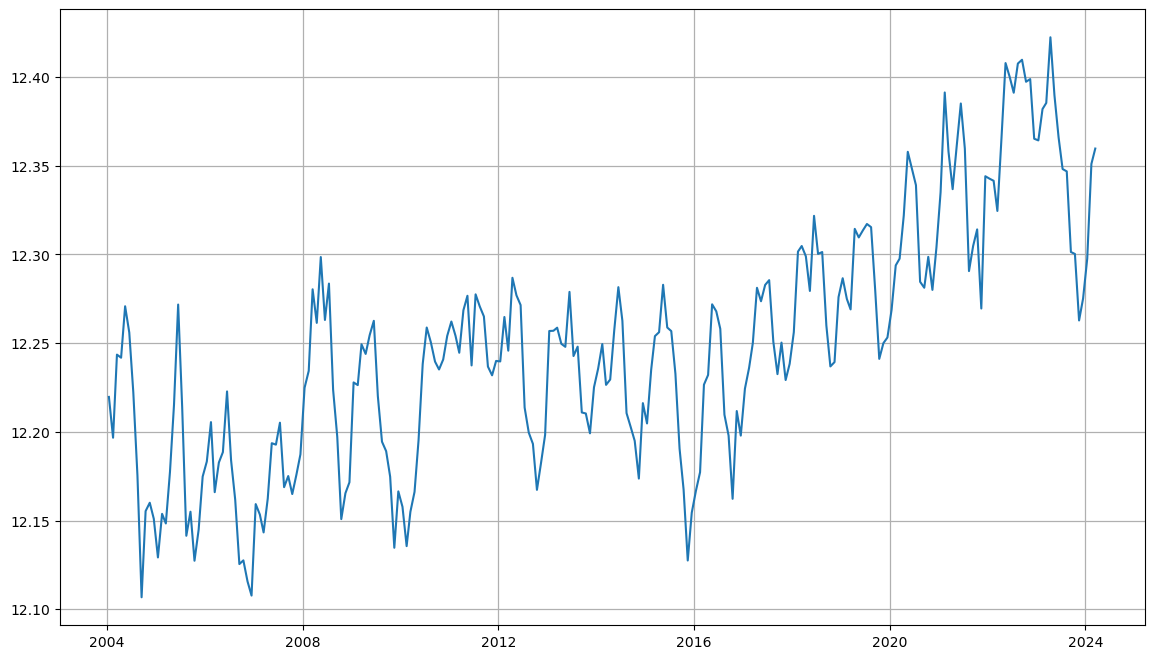

In [28]:
fig, ax = plt.subplots(1 , 1 , figsize = (14,8))
ax.plot(RG.time,
        RG.temperature.sel(lat=slice( -60, 60)).mean(dim='lat').mean(dim='lon').sel(pre=200, method='nearest'),
        label = '200')
ax.grid(linestyle='-', linewidth=.9);

In [29]:
RG.to_netcdf('./Data/RG_Global_'+str(RG.time[0].dt.strftime('%Y-%m').values)+'_'+str(RG.time[-1].dt.strftime('%Y-%m').values)+'.nc')

In [ ]:
RG2 = RG.interp(pre=np.arange(2.5,1980,10), method="linear")